In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables
import beta
import getMasks
import getPlots
import getConversions

In [2]:
bins = 200

## Driver Code

In [15]:
def fireDriver(simulation, snapshot):
    
    # Get the parameters from the config file
    params = allvariables.getparamsnotebook(f"{simulation}_inner_{snapshot}.yaml")
    
    # Declare parameters
    snap, sim, sim_dir, sat_id_dir, rmin, rmax, sat_mask, ananke_name, \
            photo_sys, cmd_magnames, app_mag_lim_lo, app_mag_lim_hi, \
            abs_mag_lim_lo, abs_mag_lim_hi,ananke_r_max, fsample = params
        
    # Convert snapshot number to redshift
    times_path = '{}snapshot_times.txt'.format(sim_dir)
    times = np.loadtxt(times_path, skiprows=3)
    redshift = times[snap, 2]
    
    # Create gizmo part object
    part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=sim_dir,
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)
    
    # Create satellite mask
    if simulation == 'm12b':
        print("Removed Satellite")
        satellite_mask = getPlots.removeSatellite(part, sat_id_dir)
    else:
        print("Could not remove Satellite")
        satellite_mask = np.ones(len(part['star'].prop('host.distance')), dtype=bool)
    
    # Declare fire params
    firePos = part['star'].prop('host.distance') # star position in kpc
    fireMass = part['star']['mass']              # star mass in Msun
    fireVel = part['star'].prop('host.velocity') # star velocity in km/s
    
    firePosSat = firePos[satellite_mask]
    fireMassSat = fireMass[satellite_mask]
    fireVelSat = fireVel[satellite_mask]
    
    # Compute radial distance
    fireRadialSat = np.sqrt((firePosSat[:,0])**2 + (firePosSat[:,1])**2 + (firePosSat[:,2])**2)
    
    # Convert to galactic coordinates
    fireGlon, fireGlat = getConversions.xyz_to_galactic(firePosSat[:,0], firePosSat[:,1], firePosSat[:,2])
    
    # Mask out disk
    disk = (fireGlat < 20) & (fireGlat > -20)
    fireGlon = fireGlon[~disk]
    fireGlat = fireGlat[~disk]
    
    # Create region masks
    region1 = (fireGlon <= 180) & (fireGlat >= 0)
    region2 = (fireGlon >= 180) & (fireGlat >= 0)
    region3 = (fireGlon <= 180) & (fireGlat <= 0)
    region4 = (fireGlon >= 180) & (fireGlat <= 0)
    
    # Calculate density parameters for regions
    fireEdgesSatRegion1, fireDensitySatRegion1 = getPlots.densityParams(fireRadialSat[~disk][region1], bins, rmin, rmax)
    fireEdgesSatRegion2, fireDensitySatRegion2 = getPlots.densityParams(fireRadialSat[~disk][region2], bins, rmin, rmax)
    fireEdgesSatRegion3, fireDensitySatRegion3 = getPlots.densityParams(fireRadialSat[~disk][region3], bins, rmin, rmax)
    fireEdgesSatRegion4, fireDensitySatRegion4 = getPlots.densityParams(fireRadialSat[~disk][region4], bins, rmin, rmax)
    
    # Normalize
    fireDensitySatRegion1Norm = getPlots.normalize_data(fireDensitySatRegion1)
    fireDensitySatRegion2Norm = getPlots.normalize_data(fireDensitySatRegion2)
    fireDensitySatRegion3Norm = getPlots.normalize_data(fireDensitySatRegion3)
    fireDensitySatRegion4Norm = getPlots.normalize_data(fireDensitySatRegion4)
    
    # Plot the density profile with interpolated values
    fig, ax = plt.subplots()
    ax.loglog(fireEdgesSatRegion1[:-1], fireDensitySatRegion1Norm, label='region 1')
    ax.loglog(fireEdgesSatRegion2[:-1], fireDensitySatRegion2Norm, label='region 2')
    ax.loglog(fireEdgesSatRegion3[:-1], fireDensitySatRegion3Norm, label='region 3')
    ax.loglog(fireEdgesSatRegion4[:-1], fireDensitySatRegion4Norm, label='region 4')
    ax.set_xlabel('Radius [log kpc]')
    ax.set_ylabel('Density [log stars/kpc$^3$]')
    ax.set_xlim(rmin, rmax)
    ax.legend()
    plt.title('Normalized FIRE Density Profile By Region')
    plt.show()

[356, 'm12b', '/home/jovyan/data/fire2/m12b_res7100/', '/home/jovyan/home/tracked/m12b/all_LMC_inds.txt', 5, 300, True, 'm12b_inner_356', 'padova/LSST', 'rmag,gmag-rmag', 17.0, 27.5, -7.0, 10.0, 1000, 0.0005]

# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12b_res7100/snapshot_times.txt

* input redshift = 0.59796441:  using snapshot index = 356, redshift = 0.598


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12b_res7100/output/snapdir_356/snapshot_356.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 64829958 particles
    star      (id = 4): 10126790 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_356.0.hdf5
    snapshot_356.1.hdf5
    snapshot_356.2.hdf5
    snapshot_356.3.hdf5
    snapshot_356.4.hdf5
    snapshot_35

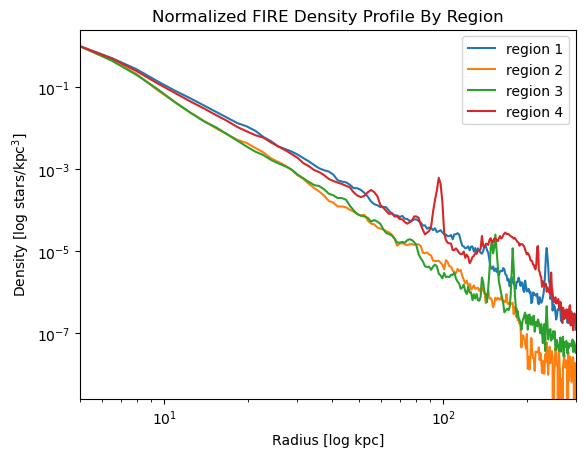

In [16]:
fireDriver('m12b', '356')

In [17]:
#fireDriver('m12b', '396')

In [18]:
#fireDriver('m12b', '600')

[600, 'm12i', '/home/jovyan/data/fire2/m12i_res7100/', '/home/jovyan/home/tracked/m12i/all_LMC_inds.txt', 5, 300, True, 'm12i_inner_600', 'padova/LSST', 'rmag,gmag-rmag', 17.0, 27.5, -7.0, 10.0, 1000, 0.0005]

# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12i_res7100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  home

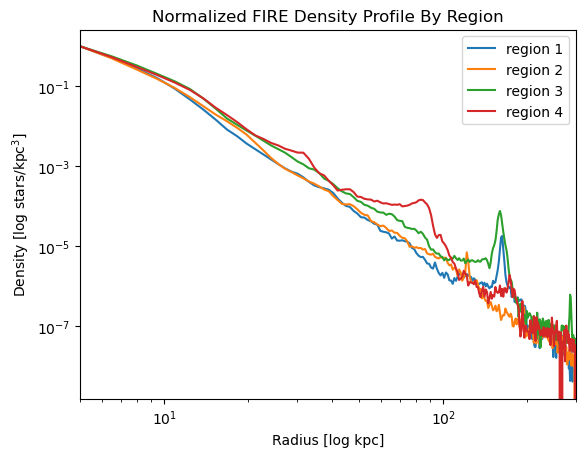

In [39]:
fireDriver('m12i', '600')

## m12b snapshot 356

In [20]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook("m12b_inner_356.yaml")

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

### Get FIRE Data

In [21]:
# Convert snapshot number to redshift
times_path = '{}snapshot_times.txt'.format(sim_dir)
times = np.loadtxt(times_path, skiprows=3)
redshift = times[snap, 2]

part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=sim_dir,
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12b_res7100/snapshot_times.txt

* input redshift = 0.59796441:  using snapshot index = 356, redshift = 0.598


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12b_res7100/output/snapdir_356/snapshot_356.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 64829958 particles
    star      (id = 4): 10126790 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_356.0.hdf5
    snapshot_356.1.hdf5
    snapshot_356.2.hdf5
    snapshot_356.3.hdf5
    snapshot_356.4.hdf5
    snapshot_356.5.hdf5
    snapshot_356.6.hdf5
    snapshot_356.7.hdf5

* reading cosmological parameters from:  home/jovyan/data/fire2/m12b_res7100/initial_condition/ic_agora_m12b.conf

* checking sanity of particle proper

### Remove Satellite

In [22]:
satellite_mask = getPlots.removeSatellite(part, sat_id_dir)

### Density Plot

In [23]:
firePos = part['star'].prop('host.distance') # star position in kpc
fireMass = part['star']['mass']              # star mass in Msun
fireVel = part['star'].prop('host.velocity') # star velocity in km/s

In [24]:
firePosSat = firePos[satellite_mask]
fireMassSat = fireMass[satellite_mask]
fireVelSat = fireVel[satellite_mask]

In [25]:
# Compute radial distance
fireRadialSat = np.sqrt((firePosSat[:,0])**2 + (firePosSat[:,1])**2 + (firePosSat[:,2])**2)

In [26]:
# Calculate density parameters
fireEdgesSat, fireDensitySat = getPlots.densityParams(fireRadialSat, bins, rmin, rmax)

In [27]:
# Normalize
fireDensitySatNorm = getPlots.normalize_data(fireDensitySat)

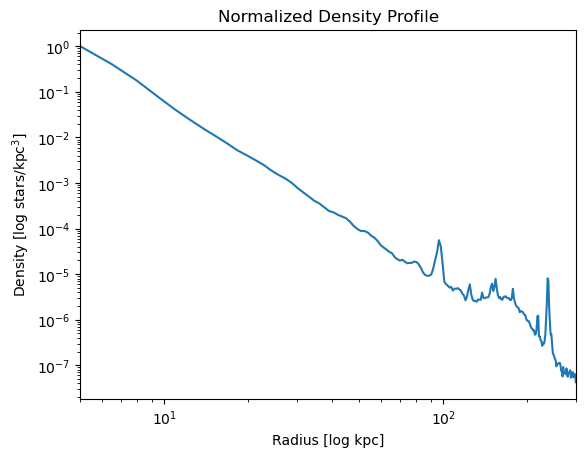

In [28]:
# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], fireDensitySatNorm)
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
#ax.legend()
plt.title('Normalized Density Profile')
plt.show()

### Galactic Coords

In [29]:
fireGlon, fireGlat = getConversions.xyz_to_galactic(firePosSat[:,0], firePosSat[:,1], firePosSat[:,2])

### Disk Mask

In [30]:
# Declare mask that contains disk values
disk = (fireGlat < 20) & (fireGlat > -20)

In [31]:
fireGlon = fireGlon[~disk]
fireGlat = fireGlat[~disk]

### Region Masks

In [32]:
# Create region masks
region1 = (fireGlon <= 180) & (fireGlat >= 0)
region2 = (fireGlon >= 180) & (fireGlat >= 0)
region3 = (fireGlon <= 180) & (fireGlat <= 0)
region4 = (fireGlon >= 180) & (fireGlat <= 0)

### Region Density Plot

In [33]:
# Calculate density parameters for regions
fireEdgesSatRegion1, fireDensitySatRegion1 = getPlots.densityParams(fireRadialSat[~disk][region1], bins, rmin, rmax)
fireEdgesSatRegion2, fireDensitySatRegion2 = getPlots.densityParams(fireRadialSat[~disk][region2], bins, rmin, rmax)
fireEdgesSatRegion3, fireDensitySatRegion3 = getPlots.densityParams(fireRadialSat[~disk][region3], bins, rmin, rmax)
fireEdgesSatRegion4, fireDensitySatRegion4 = getPlots.densityParams(fireRadialSat[~disk][region4], bins, rmin, rmax)

In [34]:
fireDensitySatRegion1Norm = getPlots.normalize_data(fireDensitySatRegion1)
fireDensitySatRegion2Norm = getPlots.normalize_data(fireDensitySatRegion2)
fireDensitySatRegion3Norm = getPlots.normalize_data(fireDensitySatRegion3)
fireDensitySatRegion4Norm = getPlots.normalize_data(fireDensitySatRegion4)

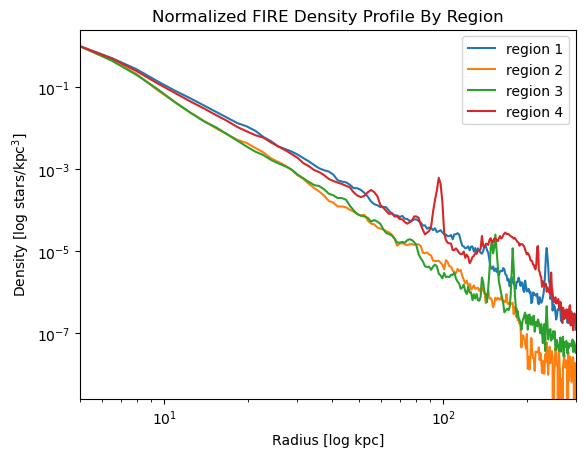

In [35]:
# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion1Norm, label='region 1')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion2Norm, label='region 2')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion3Norm, label='region 3')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion4Norm, label='region 4')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Normalized FIRE Density Profile By Region')
plt.show()

### Smoothing

In [40]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

window_length = 11  # Window length for the Savitzky-Golay filter
polyorder = 3       # Polynomial order for the Savitzky-Golay filter

fireDensitySatRegion1Norm_smooth = savgol_filter(fireDensitySatRegion1Norm, window_length, polyorder)
fireDensitySatRegion2Norm_smooth = savgol_filter(fireDensitySatRegion2Norm, window_length, polyorder)
fireDensitySatRegion3Norm_smooth = savgol_filter(fireDensitySatRegion3Norm, window_length, polyorder)
fireDensitySatRegion4Norm_smooth = savgol_filter(fireDensitySatRegion4Norm, window_length, polyorder)

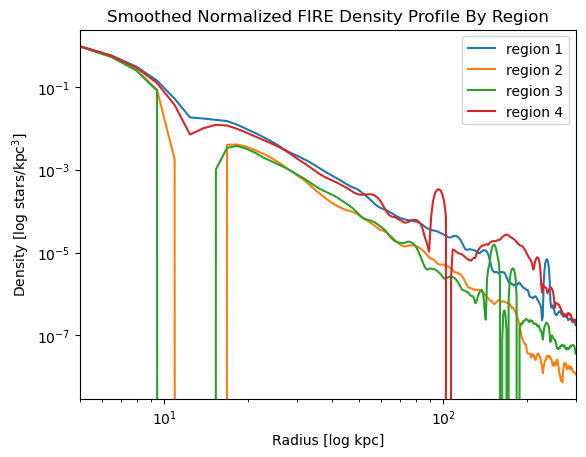

In [41]:
# Plot the smoothed density profiles
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion1Norm_smooth, label='region 1')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion2Norm_smooth, label='region 2')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion3Norm_smooth, label='region 3')
ax.loglog(fireEdgesSat[:-1], fireDensitySatRegion4Norm_smooth, label='region 4')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Smoothed Normalized FIRE Density Profile By Region')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (201,)

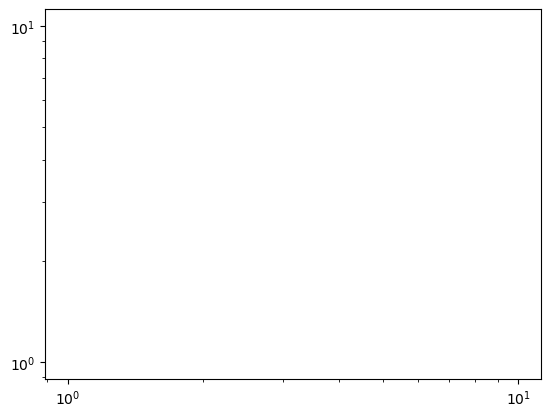

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define the moving average function
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Set the window size for the moving average
window_size = 400

# Smooth the density profiles
smoothed_density_region1 = moving_average(fireDensitySatRegion1Norm, window_size)
smoothed_density_region2 = moving_average(fireDensitySatRegion2Norm, window_size)
smoothed_density_region3 = moving_average(fireDensitySatRegion3Norm, window_size)
smoothed_density_region4 = moving_average(fireDensitySatRegion4Norm, window_size)

# Trim fireEdgesSat to match the smoothed density arrays
trimmed_fireEdgesSat = fireEdgesSat[:-window_size]

# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(trimmed_fireEdgesSat, smoothed_density_region1, label='region 1')
ax.loglog(trimmed_fireEdgesSat, smoothed_density_region2, label='region 2')
ax.loglog(trimmed_fireEdgesSat, smoothed_density_region3, label='region 3')
ax.loglog(trimmed_fireEdgesSat, smoothed_density_region4, label='region 4')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Smoothed Normalized FIRE Density Profile By Region')
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing
smoothed_density_region1 = gaussian_filter1d(fireDensitySatRegion1Norm, sigma=10)
smoothed_density_region2 = gaussian_filter1d(fireDensitySatRegion2Norm, sigma=10)
smoothed_density_region3 = gaussian_filter1d(fireDensitySatRegion3Norm, sigma=10)
smoothed_density_region4 = gaussian_filter1d(fireDensitySatRegion4Norm, sigma=10)

# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], smoothed_density_region1, label='region 1')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region2, label='region 2')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region3, label='region 3')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region4, label='region 4')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Gaussian Smoothed Normalized FIRE Density Profile By Region')
plt.show()

In [ ]:
from scipy.signal import medfilt

# Apply median filtering
smoothed_density_region1 = medfilt(fireDensitySatRegion1Norm, kernel_size=9)
smoothed_density_region2 = medfilt(fireDensitySatRegion2Norm, kernel_size=9)
smoothed_density_region3 = medfilt(fireDensitySatRegion3Norm, kernel_size=9)
smoothed_density_region4 = medfilt(fireDensitySatRegion4Norm, kernel_size=9)

# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(fireEdgesSat[:-1], smoothed_density_region1, label='region 1')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region2, label='region 2')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region3, label='region 3')
ax.loglog(fireEdgesSat[:-1], smoothed_density_region4, label='region 4')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Medfilt Smoothed Normalized FIRE Density Profile By Region')
plt.show()